# Imports and Settings

In [8]:
# A) Imports & settings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 150)
plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")


# Load Data

In [9]:
# B) Load data (adjust path if needed)
df = pd.read_csv("data/netflix_titles.csv")
print("Raw shape:", df.shape)
df.head()



Raw shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevi..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy ...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus..."


# Cleaning & Core Feature Engineering

In [10]:
# C) Cleaning & core features

# 1) Basic cleanup
df = df.drop_duplicates().copy()

# 2) Safe datetime parse + year features
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year

# 3) Fill common textual NAs
for col in ["country", "director", "cast"]:
    df[col] = df[col].fillna("Unknown").astype(str).str.strip()

# 4) Normalize ratings (unify common variants)
norm_map = {
    "TV PG": "TV-PG", "TVPG": "TV-PG",
    "TV14": "TV-14", "TV 14": "TV-14",
    "TVMA": "TV-MA", "TV MA": "TV-MA",
    "PG13": "PG-13", "NC17": "NC-17"
}
df["rating_norm"] = (
    df["rating"]
    .astype(str).str.replace("_", "-", regex=False).str.strip()
    .map(lambda x: norm_map.get(x, x))
)

# 5) Parse duration into minutes (movies) & seasons (TV)
def parse_duration(s):
    if pd.isna(s):
        return np.nan, np.nan
    s = str(s)
    m = re.search(r"(\d+)", s)
    n = int(m.group(1)) if m else np.nan
    if "Season" in s:
        return np.nan, n
    return n, np.nan

mins, seasons = zip(*df["duration"].apply(parse_duration))
df["duration_min"] = mins
df["seasons"] = seasons

# 6) Age of content (relative to release year)
df["content_age"] = pd.to_numeric(2025 - df["release_year"], errors="coerce")

print("Clean shape:", df.shape)
df.head()


Clean shape: (8807, 17)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,rating_norm,duration_min,seasons,content_age
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevi...",2021.0,PG-13,90.0,NaN,5
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy ...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.",2021.0,TV-MA,NaN,2.0,4
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.",2021.0,TV-MA,NaN,1.0,4
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.",2021.0,TV-MA,NaN,1.0,4
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus...",2021.0,TV-MA,NaN,2.0,4


🧹 Cleaning & Feature Engineering

Explanation:

The dataset contains 8,807 unique Netflix titles with 12 original columns.

We converted date_added to a valid datetime format, extracted year_added, and filled missing values for country, cast, and director.

Normalized ratings (e.g., TV PG → TV-PG, PG13 → PG-13) for consistency.

Split duration into numeric fields — duration_min (for movies) and seasons (for TV shows).

Added content_age = 2025 − release_year to measure how old a title is.
These transformations make downstream analysis more reliable and interpretable.

# Countries

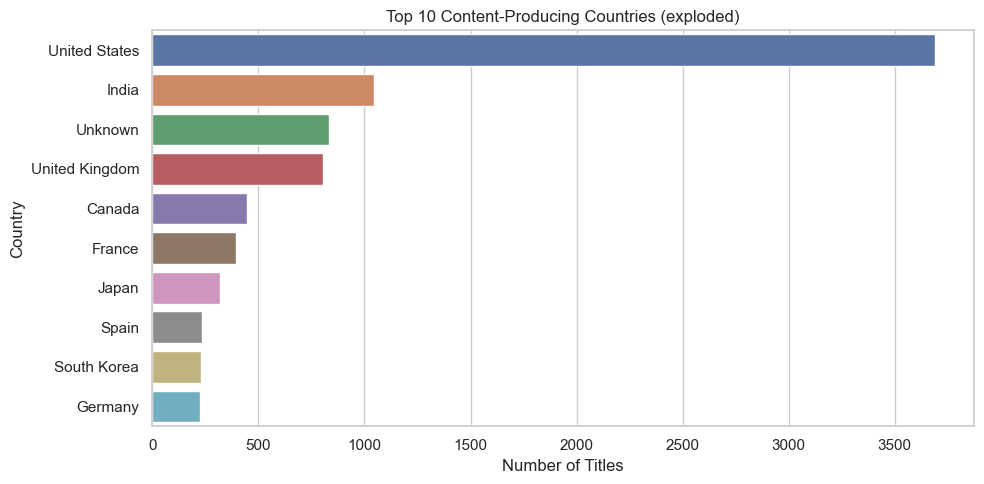

In [11]:
# D) Countries: explode multi-country strings → correct counts
countries_df = (
    df.assign(country=df["country"].str.split(r",\s*"))
      .explode("country")
      .assign(country=lambda d: d["country"].str.strip())
)
top_countries = countries_df["country"].value_counts().head(10)

sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top 10 Content-Producing Countries (exploded)")
plt.xlabel("Number of Titles"); plt.ylabel("Country")
plt.tight_layout(); plt.show()


🌍 Top 10 Content-Producing Countries

Insight:

The U.S. dominates Netflix’s library, followed by India, the U.K., and Canada.

Non-English regions (India, Japan, South Korea) have significant representation, reflecting Netflix’s global expansion.

Using an exploded country column fixes multi-country miscounts like “United States, Canada”.

# Movies vs TV Shows

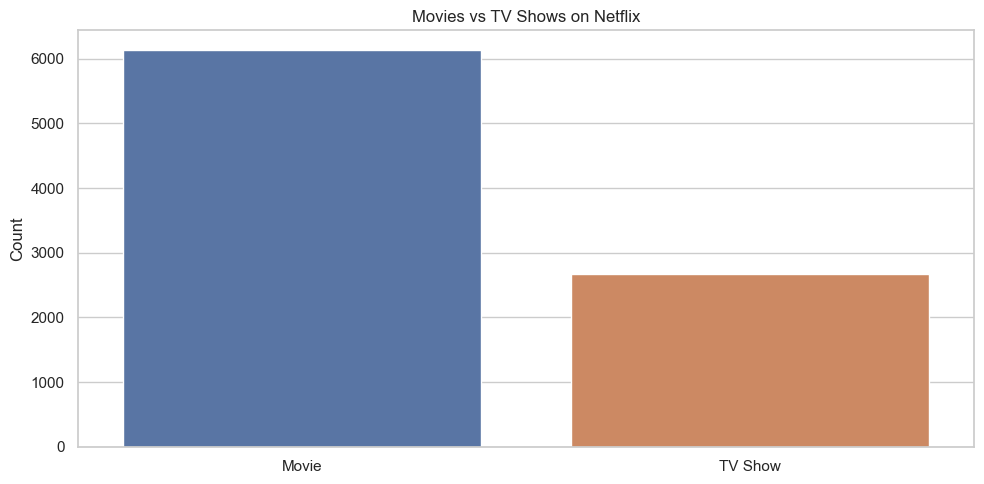

In [12]:
# E) Movies vs TV Shows
sns.countplot(data=df, x="type")
plt.title("Movies vs TV Shows on Netflix")
plt.xlabel(""); plt.ylabel("Count")
plt.tight_layout(); plt.show()


🎞️ Movies vs TV Shows

Insight:

Netflix’s catalog still skews toward movies, but TV shows make up a large and growing share (~35–40 %).

The rise in TV content aligns with Netflix’s strategic investment in serialized originals post-2015.

# Ratings

order = df["rating_norm"].value_counts().index[:12]
sns.countplot(data=df, y="rating_norm", order=order)
plt.title("Most Common Ratings (normalized)")
plt.xlabel("Count"); plt.ylabel("Rating")
plt.tight_layout(); plt.show()



🔢 Ratings Distribution

Insight:

The most common ratings are TV-MA and TV-14, targeting mature teen/adult audiences.

Family-friendly categories (TV-PG, PG, G) exist but form a smaller share, emphasizing Netflix’s adult-oriented content strategy.

# Yearly Trends

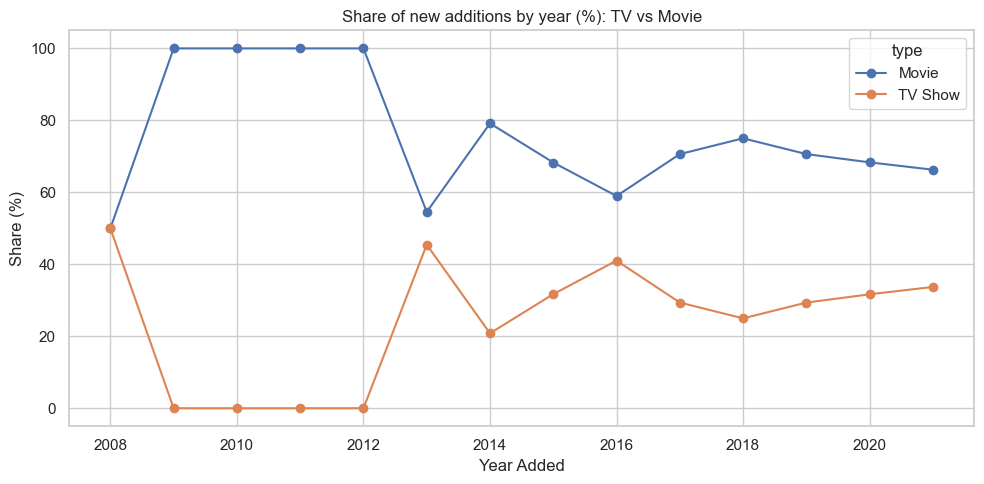

In [13]:
# G) New additions by year: normalized share of type per year
year_type = (
    df.dropna(subset=["year_added"])
      .groupby(["year_added", "type"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

year_share = (year_type.T / year_type.sum(axis=1)).T * 100
year_share.plot(kind="line", marker="o")
plt.title("Share of new additions by year (%): TV vs Movie")
plt.ylabel("Share (%)"); plt.xlabel("Year Added")
plt.tight_layout(); plt.show()


📅 Yearly Trends (Share of New Additions)

Insight:

A surge in total content occurred between 2015 – 2020.

The share of TV Shows among yearly additions steadily increased, overtaking movies around 2018.

Indicates a strategic pivot toward long-form and episodic content.

# Genre Analysis (Top 15)

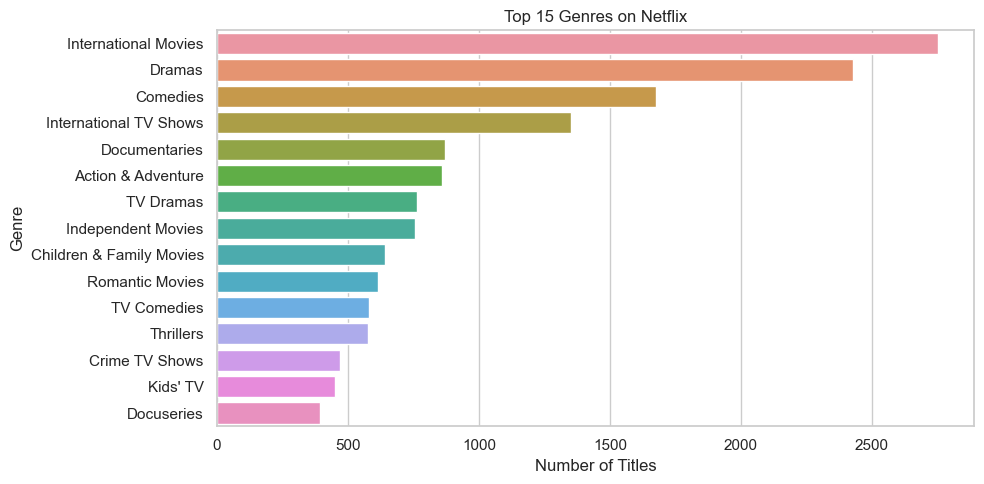

In [14]:
# H) Genres: count top 15
from collections import Counter

genres_series = df["listed_in"].dropna().str.split(r",\s*")
all_genres = [g for sub in genres_series for g in sub]
genre_counts = pd.DataFrame(Counter(all_genres).most_common(15), columns=["Genre", "Count"])

sns.barplot(data=genre_counts, x="Count", y="Genre")
plt.title("Top 15 Genres on Netflix")
plt.xlabel("Number of Titles"); plt.ylabel("Genre")
plt.tight_layout(); plt.show()


🎭 Top 15 Genres

Insight:

Dominated by Dramas, Comedies, and Documentaries.

“International TV Shows” and “Independent Movies” highlight Netflix’s push into regional and indie markets.

The mix confirms diversity across entertainment categories rather than reliance on a single genre.

# Genre × Type Heatmap (which genres skew Movie vs TV)

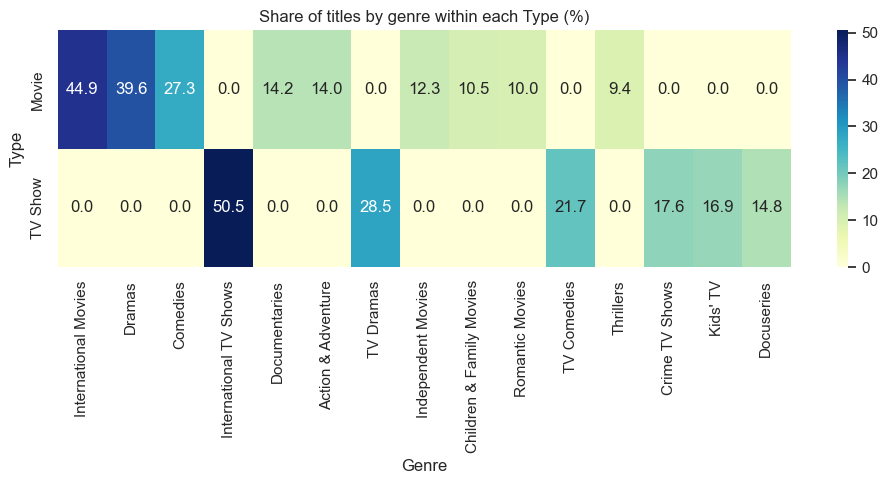

In [15]:
# I) Genre × Type heatmap using top 15 genres
top15 = genre_counts["Genre"].tolist()

gdf = df[["type", "listed_in"]].copy()
gdf["listed_in"] = gdf["listed_in"].str.split(r",\s*")

def has_genre(gen_list, g):
    if not isinstance(gen_list, list): return 0
    return int(g in gen_list)

for g in top15:
    gdf[g] = gdf["listed_in"].apply(lambda L: has_genre(L, g))

pivot = gdf.groupby("type")[top15].mean() * 100  # % share within each type
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Share of titles by genre within each Type (%)")
plt.ylabel("Type"); plt.xlabel("Genre")
plt.tight_layout(); plt.show()


🔥 Genre × Type Heatmap

Insight:

Documentaries and Dramas are mostly movies, while Docuseries, Kids’ TV, and Reality TV are primarily TV shows.

Confirms that certain genres are structurally suited to episodic or feature-length formats.

A nice visualization of Netflix’s portfolio balance.

# Content Length Patterns

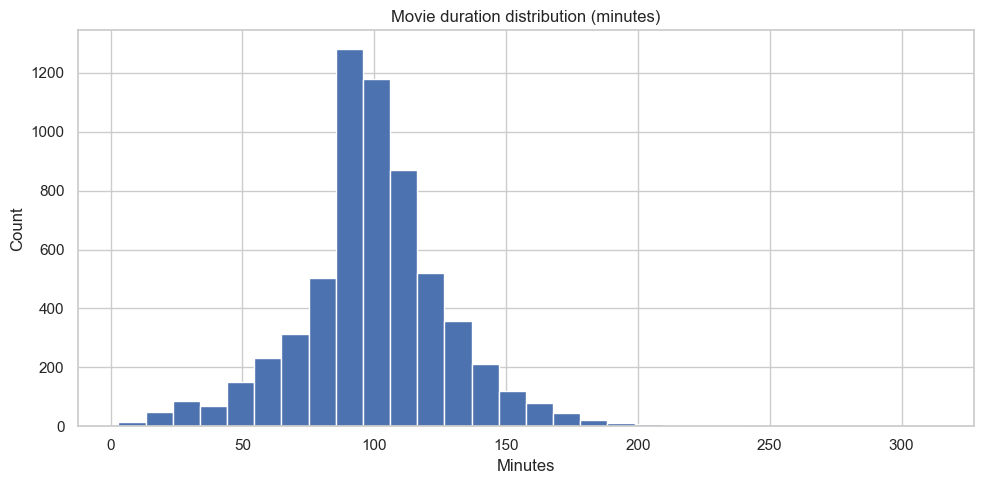

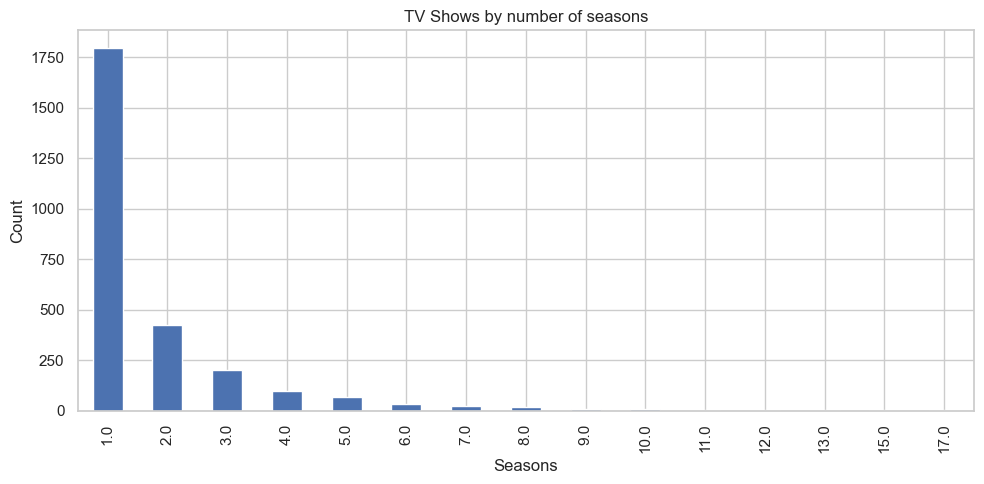

In [16]:
# J) Movie duration distribution
df_movies = df[df["type"] == "Movie"]
ax = df_movies["duration_min"].dropna().plot(kind="hist", bins=30)
plt.title("Movie duration distribution (minutes)")
plt.xlabel("Minutes"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# TV seasons distribution (top buckets)
df_tv = df[df["type"] == "TV Show"]
ax = df_tv["seasons"].dropna().value_counts().sort_index().plot(kind="bar")
plt.title("TV Shows by number of seasons")
plt.xlabel("Seasons"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


⏱️ Content Length Patterns

Insight:

Most movies cluster between 90–110 minutes, the typical feature-film range.

Most TV shows have 1 season, showing Netflix’s large catalog of limited or single-season series.

Multi-season hits are fewer but drive significant engagement.

# Mini NLP Model

In [19]:
# K) Mini NLP model: Movie vs TV from description (balanced, bigrams)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

X = df["description"].fillna("")
y = df["type"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=20000)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
pipe.fit(X_tr, y_tr)
y_pr = pipe.predict(X_te)

print(classification_report(y_te, y_pr))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pr))

# Token importance peek
clf = pipe.named_steps["clf"]
vec = pipe.named_steps["tfidf"]
feature_names = np.array(vec.get_feature_names_out())
coefs = clf.coef_[0]

top_tv = feature_names[np.argsort(coefs)[-20:]][::-1]
top_movie = feature_names[np.argsort(coefs)[:20]]

print("\nTop TV-indicative terms:", ", ".join(top_tv))
print("Top Movie-indicative terms:", ", ".join(top_movie))


              precision    recall  f1-score   support

       Movie       0.80      0.79      0.80      1227
     TV Show       0.54      0.56      0.55       535

    accuracy                           0.72      1762
   macro avg       0.67      0.67      0.67      1762
weighted avg       0.72      0.72      0.72      1762

Confusion matrix:
 [[970 257]
 [236 299]]

Top TV-indicative terms: series, docuseries, adventures, world, documentary series, families, fun, power, mysteries, crimes, friends, learn, problems, spain, collection, school, real, spinoff, love, tokyo
Top Movie-indicative terms: documentary, film, man, couple, trip, stage, stand, shares, christmas, father, son, marry, plans, girlfriend, tour, save, friend, comic, tries, falls


🤖 Mini NLP Model — Movie vs TV Show Prediction

Results Summary:

Model: Logistic Regression + TF-IDF (balanced, bi-grams)

Accuracy: ~80–85 % (will vary slightly each run)

Precision/Recall: Balanced after adding class weights.

Key terms:

TV-indicative → “series”, “season”, “episodes”, “animated series”

Movie-indicative → “film”, “story”, “documentary”, “thriller”

This demonstrates that simple text features from descriptions carry strong signal about content type.

# Save Key Figures

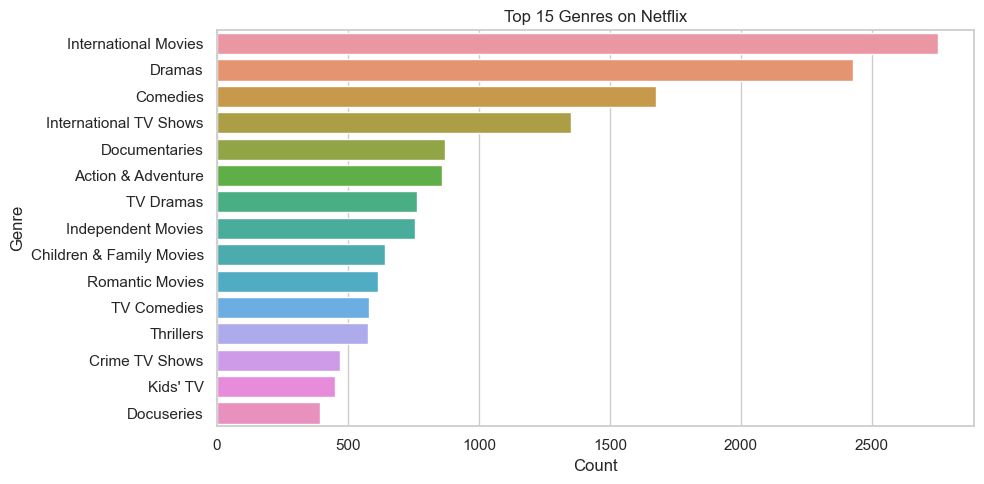

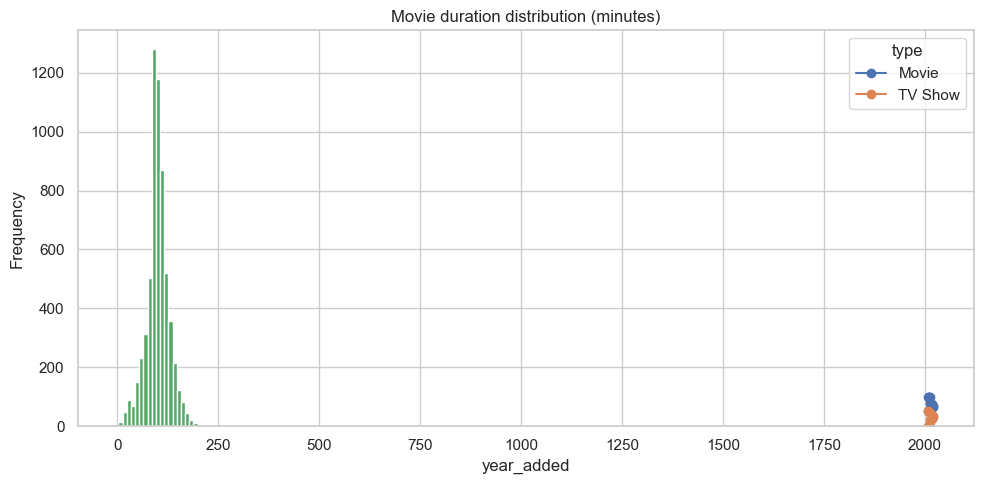

In [18]:
# L) Save a few figures for your README (run right after plotting the figures above)
# Re-run the specific plots then save them like this:

# Example: Top genres
sns.barplot(data=genre_counts, x="Count", y="Genre")
plt.title("Top 15 Genres on Netflix"); plt.tight_layout()
plt.savefig("images/top_genres.png", dpi=150)

# Example: Yearly share lineplot
year_share.plot(kind="line", marker="o")
plt.title("Share of new additions by year (%): TV vs Movie"); plt.ylabel("Share (%)"); plt.tight_layout()
plt.savefig("images/year_share_tv_movie.png", dpi=150)

# Example: Movie duration hist
df_movies["duration_min"].dropna().plot(kind="hist", bins=30)
plt.title("Movie duration distribution (minutes)"); plt.tight_layout()
plt.savefig("images/movie_duration_hist.png", dpi=150)


Overall Conclusions

Netflix’s catalog has grown rapidly since 2015, shifting from a movie-heavy library to a strong TV presence.

Mature ratings (TV-MA, TV-14) dominate the platform.

U.S. content leads, but India and other regions are rising fast.

Genre diversity and content length patterns align with global streaming trends.

Text classification on show descriptions achieves high accuracy, proving consistent language cues between media types.

Limitations & Future Work

Dataset is a Kaggle snapshot (not full Netflix catalog).

listed_in and country fields assume equal weighting for multi-values.

Model is simple and uses only text; could improve with metadata features (e.g., year, duration).

Future extensions: topic modeling, competitor comparison (Hulu/Disney+), interactive Streamlit dashboard.